## 基于Softmax的Fashion-MNIST分类
FashionMNIST 是一个替代 MNIST 手写数字集的图像数据集。 它是由 Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自 10 种类别的共 7 万个不同商品的正面图片。FashionMNIST 的大小、格式和训练集/测试集划分与原始的 MNIST 完全一致。60000/10000 的训练测试数据划分，28x28 的灰度图片。

Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。

### 分类问题
让我们考虑一个简单的图像分类问题，其输入图像的高和宽均为2像素，且色彩为灰度。这样每个像素值都可以用一个标量表示。我们将图像中的4像素分别记为$x_1, x_2, x_3, x_4$。假设训练数据集中图像的真实标签为狗、猫或鸡（假设可以用4像素表示出这3种动物），这些标签分别对应离散值$y_1, y_2, y_3$。

我们通常使用离散的数值来表示类别，例如$y_1=1, y_2=2, y_3=3$。如此，一张图像的标签为1、2和3这3个数值中的一个。虽然我们仍然可以使用回归模型来进行建模，并将预测值就近定点化到1、2和3这3个离散值之一，但这种连续值到离散值的转化通常会影响到分类质量。因此我们一般使用更加适合离散值输出的模型来解决分类问题。

### softmax 回归模型
softmax回归跟线性回归一样将输入特征与权重做线性叠加。与线性回归的一个主要不同在于，softmax回归的输出值个数等于标签里的类别数。因为一共有4种特征和3种输出动物类别，所以权重包含12个标量（带下标的$w$）、偏差包含3个标量（带下标的$b$），且对每个输入计算$o_1, o_2, o_3$这3个输出：

$$ \begin{aligned} o_1 &= x_1 w_{11} + x_2 w_{21} + x_3 w_{31} + x_4 w_{41} + b_1,\\ o_2 &= x_1 w_{12} + x_2 w_{22} + x_3 w_{32} + x_4 w_{42} + b_2,\\ o_3 &= x_1 w_{13} + x_2 w_{23} + x_3 w_{33} + x_4 w_{43} + b_3. \end{aligned} $$

图3.2用神经网络图描绘了上面的计算。softmax回归同线性回归一样，也是一个单层神经网络。由于每个输出$o_1, o_2, o_3$的计算都要依赖于所有的输入$x_1, x_2, x_3, x_4$，softmax回归的输出层也是一个全连接层。

### softmax运算
既然分类问题需要得到离散的预测输出，一个简单的办法是将输出值$o_i$当作预测类别是$i$的置信度，并将值最大的输出所对应的类作为预测输出，即输出$\operatorname*{argmax}_i o_i$。例如，如果$o_1,o_2,o_3$分别为$0.1,10,0.1$，由于$o_2$最大，那么预测类别为2，其代表猫。

然而，直接使用输出层的输出有两个问题。一方面，由于输出层的输出值的范围不确定，我们难以直观上判断这些值的意义。例如，刚才举的例子中的输出值10表示“很置信”图像类别为猫，因为该输出值是其他两类的输出值的100倍。但如果$o_1=o_3=10^3$，那么输出值10却又表示图像类别为猫的概率很低。另一方面，由于真实标签是离散值，这些离散值与不确定范围的输出值之间的误差难以衡量。

softmax运算符（softmax operator）解决了以上两个问题。它通过下式将输出值变换成值为正且和为1的概率分布：

$$\hat{y}_1, \hat{y}_2, \hat{y}_3 = \text{softmax}(o_1, o_2, o_3),$$

其中

$$ \hat{y}1 = \frac{ \exp(o_1)}{\sum{i=1}^3 \exp(o_i)},\quad \hat{y}2 = \frac{ \exp(o_2)}{\sum{i=1}^3 \exp(o_i)},\quad \hat{y}3 = \frac{ \exp(o_3)}{\sum{i=1}^3 \exp(o_i)}. $$

容易看出$\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$且$0 \leq \hat{y}_1, \hat{y}_2, \hat{y}_3 \leq 1$，因此$\hat{y}_1, \hat{y}_2, \hat{y}_3$是一个合法的概率分布。这时候，如果$\hat{y}_2=0.8$，不管$\hat{y}_1$和$\hat{y}_3$的值是多少，我们都知道图像类别为猫的概率是80%。此外，我们注意到

$$\operatorname*{argmax}_i o_i = \operatorname*{argmax}_i \hat y_i,$$

因此softmax运算不改变预测类别输出。

### 交叉熵损失函数
前面提到，使用softmax运算后可以更方便地与离散标签计算误差。我们已经知道，softmax运算将输出变换成一个合法的类别预测分布。实际上，真实标签也可以用类别分布表达：对于样本$i$，我们构造向量$\boldsymbol{y}^{(i)}\in \mathbb{R}^{q}$ ，使其第$y^{(i)}$（样本$i$类别的离散数值）个元素为1，其余为0。这样我们的训练目标可以设为使预测概率分布$\boldsymbol{\hat y}^{(i)}$尽可能接近真实的标签概率分布$\boldsymbol{y}^{(i)}$。

我们可以像线性回归那样使用平方损失函数$|\boldsymbol{\hat y}^{(i)}-\boldsymbol{y}^{(i)}|^2/2$。然而，想要预测分类结果正确，我们其实并不需要预测概率完全等于标签概率。例如，在图像分类的例子里，如果$y^{(i)}=3$，那么我们只需要$\hat{y}^{(i)}_3$比其他两个预测值$\hat{y}^{(i)}_1$和$\hat{y}^{(i)}_2$大就行了。即使$\hat{y}^{(i)}_3$值为0.6，不管其他两个预测值为多少，类别预测均正确。而平方损失则过于严格，例如$\hat y^{(i)}_1=\hat y^{(i)}_2=0.2$比$\hat y^{(i)}_1=0, \hat y^{(i)}_2=0.4$的损失要小很多，虽然两者都有同样正确的分类预测结果。

改善上述问题的一个方法是使用更适合衡量两个概率分布差异的测量函数。其中，交叉熵（cross entropy）是一个常用的衡量方法：

$$H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ) = -\sum_{j=1}^q y_j^{(i)} \log \hat y_j^{(i)},$$

其中带下标的$y_j^{(i)}$是向量$\boldsymbol y^{(i)}$中非0即1的元素，需要注意将它与样本$i$类别的离散数值，即不带下标的$y^{(i)}$区分。在上式中，我们知道向量$\boldsymbol y^{(i)}$中只有第$y^{(i)}$个元素$y^{(i)}{y^{(i)}}$为1，其余全为0，于是$H(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}) = -\log \hat y{y^{(i)}}^{(i)}$。也就是说，交叉熵只关心对正确类别的预测概率，因为只要其值足够大，就可以确保分类结果正确。当然，遇到一个样本有多个标签时，例如图像里含有不止一个物体时，我们并不能做这一步简化。但即便对于这种情况，交叉熵同样只关心对图像中出现的物体类别的预测概率。

假设训练数据集的样本数为$n$，交叉熵损失函数定义为 $$\ell(\boldsymbol{\Theta}) = \frac{1}{n} \sum_{i=1}^n H\left(\boldsymbol y^{(i)}, \boldsymbol {\hat y}^{(i)}\right ),$$

其中$\boldsymbol{\Theta}$代表模型参数。同样地，如果每个样本只有一个标签，那么交叉熵损失可以简写成$\ell(\boldsymbol{\Theta}) = -(1/n) \sum_{i=1}^n \log \hat y_{y^{(i)}}^{(i)}$。从另一个角度来看，我们知道最小化$\ell(\boldsymbol{\Theta})$等价于最大化$\exp(-n\ell(\boldsymbol{\Theta}))=\prod_{i=1}^n \hat y_{y^{(i)}}^{(i)}$，即最小化交叉熵损失函数等价于最大化训练数据集所有标签类别的联合预测概率。

## 1 导入模块

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time 
import sys 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

## 2 获取数据集

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
print(train_x.shape,train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


### 2.1 查看特征与标签

In [5]:
feature, label = train_x[0], train_y[0]
print(feature.shape, feature.dtype, '\t\t', train_y.shape, train_y.dtype)

(28, 28) uint8 		 (60000,) uint8


### 2.2 将数值标签转换成文本标签

In [3]:
def num_label2str_label(labels):
    text_labels =  ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

### 2.3 数据可视化

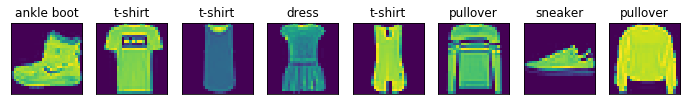

In [4]:
def draw_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)))
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
    
X, y = [], []
for i in range(8):
    X.append(train_x[i])
    y.append(train_y[i])
draw_fashion_mnist(X, num_label2str_label(y))    

### 2.4 构建数据管道

In [5]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(batch_size)

In [6]:
# 查看读取一遍训练数据需要的时间
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

0.08 sec


### 2.5数据归一化

In [10]:
train_x = train_x / 255.0
test_x = test_x / 255.0

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

### 2.6 建立softmax模型
softmax回归的输出层是一个全连接层。因此，我们添加一个输出个数为10的全连接层。 第一层是Flatten，将28 * 28的像素值，压缩成一行 (784, ) 第二层还是Dense，因为是多分类问题，激活函数使用softmax

In [8]:
tf.keras.backend.clear_session()
softmax_model = keras.Sequential([keras.layers.Flatten(input_shape=(28, 28)),
                                 keras.layers.Dense(10, activation = tf.nn.softmax)])
softmax_model.compile(optimizer ='adam', 
                      loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
softmax_model.summary()
softmax_model.fit(train_x, train_y, epochs = 5, batch_size = 256)
# softmax_model.fit(train_inter, epochs = 5) # 用数据管道训练

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


InternalError:  Blas GEMM launch failed : a.shape=(256, 784), b.shape=(784, 10), m=256, n=10, k=784
	 [[node sequential/dense/MatMul (defined at <ipython-input-8-e57b6fc88e29>:7) ]] [Op:__inference_train_function_941]

Function call stack:
train_function


## 3 模型评估

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test Acc:',test_acc)
